# Evaluation of the Progressive GAN and the Conditional Progressive GAN

### imports:

In [ ]:
import os
import yaml
import sys
sys.path.append('../..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torchsummary import summary
import pandas as pd
import seaborn as sns

from syndatagenerators.models.progressive_gan.trainer import TrainerProGAN
from syndatagenerators.data_preparation.datasets import LondonDataset, LondonDataModule
from syndatagenerators.models.progressive_gan.utils import  plot_similar_samples
from syndatagenerators.metrics.visualization import t_SNE

### initialization: load the parameters from the config file

In [ ]:
# path to config file
CONF_PATH: str =  '../models/utils/config_progan.yml'

# use of conditions?
USE_LABELS: bool = True

config = yaml.safe_load(open(CONF_PATH, 'r'))

# load parameters
data_params = config['data_params']
train_params = config['train_params']
gen_params = config['gen_params']
dis_params = config['dis_params']

### initialize the dataset

In [9]:
list_assets = ['MAC' + str(i).zfill(6) for i in range(2, data_params['n_households'] + 2)]

dataset = LondonDataset(assets=list_assets, window_length=data_params['window_len'], overlap=data_params['overlap'], ts_freq=30, train_data_dir=data_params['train_data_dir'], labels=USE_LABELS)

Train data saved


In [ ]:

# alternatively: lightning datamodule
dm = LondonDataModule(assets=list_assets, window_length=data_params['window_len'], overlap=data_params['overlap'],
                       train_data_dir=data_params['train_data_dir'], labels=USE_LABELS)

dm.setup()
print(f'Number of train samples: {dm.data_train[:].shape[0]}')
print(f'Number of val samples: {dm.data_val[:].shape[0]}')

In [5]:
NAME = train_params['name']
FILENAME = f'TrainerProGAN_{NAME}.ckpt'
ckpt_path = os.path.join(data_params['ckpt_dir'], NAME, FILENAME)

model = TrainerProGAN.load_from_checkpoint(ckpt_path)

In [6]:
def plot_samples(generator, depth: int = 0, n_rows: int = 4, n_cols: int = 4):

    z = torch.randn(n_rows*n_cols, generator.nb_features, generator.target_len).float()
    generator.eval()
    x_gen = generator(z, depth=depth, residual=False).detach()
    x_gen = torch.clamp(x_gen, 0, 1)
    x_gen = x_gen.cpu().numpy().reshape(n_rows*n_cols, -1)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10), sharex=True)
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].plot(x_gen[count, :], color='black')
            count += 1
    fig.text(0.5, 0.06, 'time steps', ha='center', va='center', fontsize=15)

    return fig

def generate_synthetic_samples(generator, depth: int = 4, size: int = 5000,
                               clip: bool = True):

    generator.eval()
    z = torch.randn(size, generator.nb_features, generator.target_len).float()
    x_gen = generator(z, depth=depth, residual=0).detach()

    if clip:
        x_gen = torch.clamp(x_gen, 0, 1)
    return x_gen

In [23]:
idx = np.random.permutation(len(dm.data))[:10000]
x_real = dm.data[idx]
x_gen = generate_synthetic_samples(model.generator, depth=5, size= len(x_real))

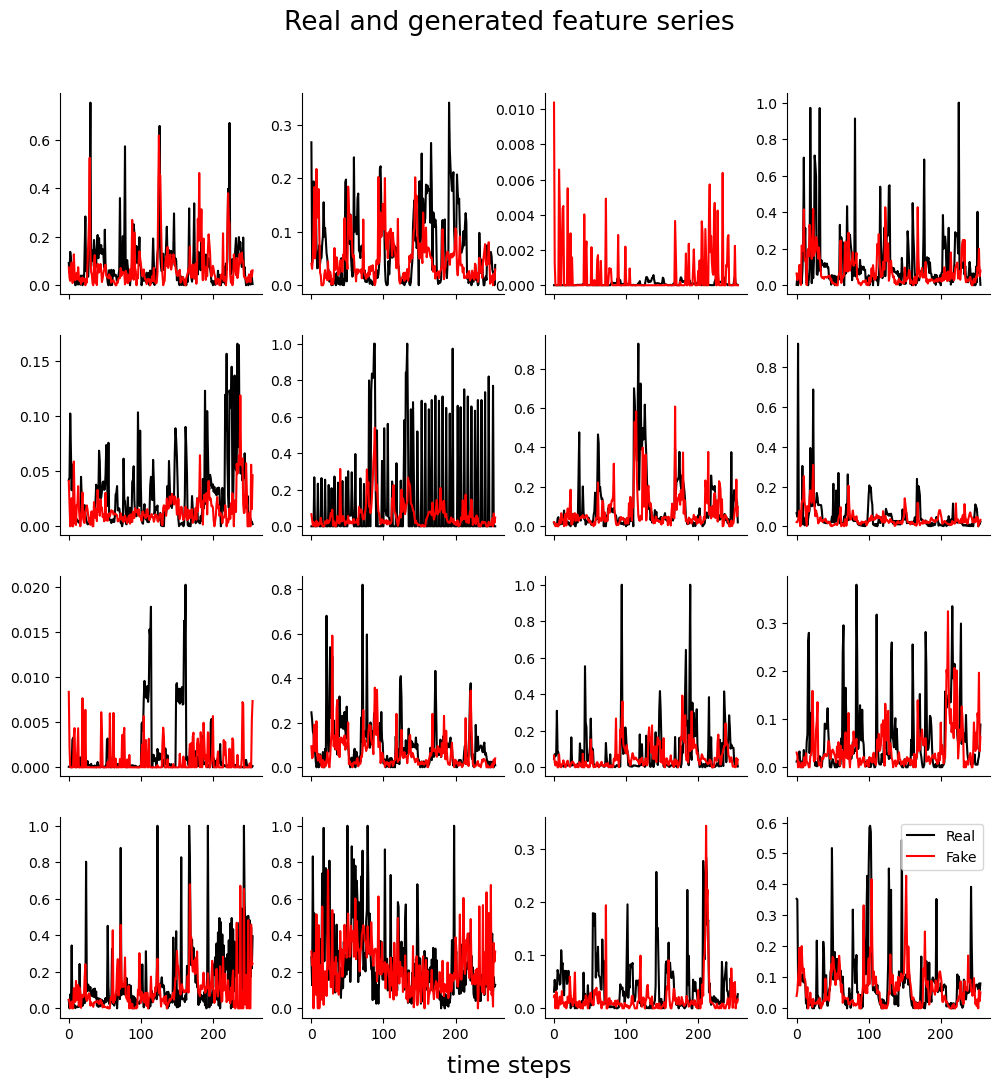

In [14]:
fig = plot_similar_samples(x_real, x_gen, figsize=(12,12))

In [15]:
x_real_embed, x_fake_embed = t_SNE(x_real, x_gen)

C:\Users\mjuergen\.conda\envs\syndatagenerators\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mjuergen\.conda\envs\syndatagenerators\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.009s...
[t-SNE] Computed neighbors for 20000 samples in 2.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

C:\Users\mjuergen\AppData\Local\Temp\ipykernel_16792\431843581.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_real_embed[:,0], x_real_embed[:,1], 'bo', color='blue', markersize=3, label='real')
C:\Users\mjuergen\AppData\Local\Temp\ipykernel_16792\431843581.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_fake_embed[:,0], x_fake_embed[:,1], 'bo', color='red', markersize=3, label='generated')


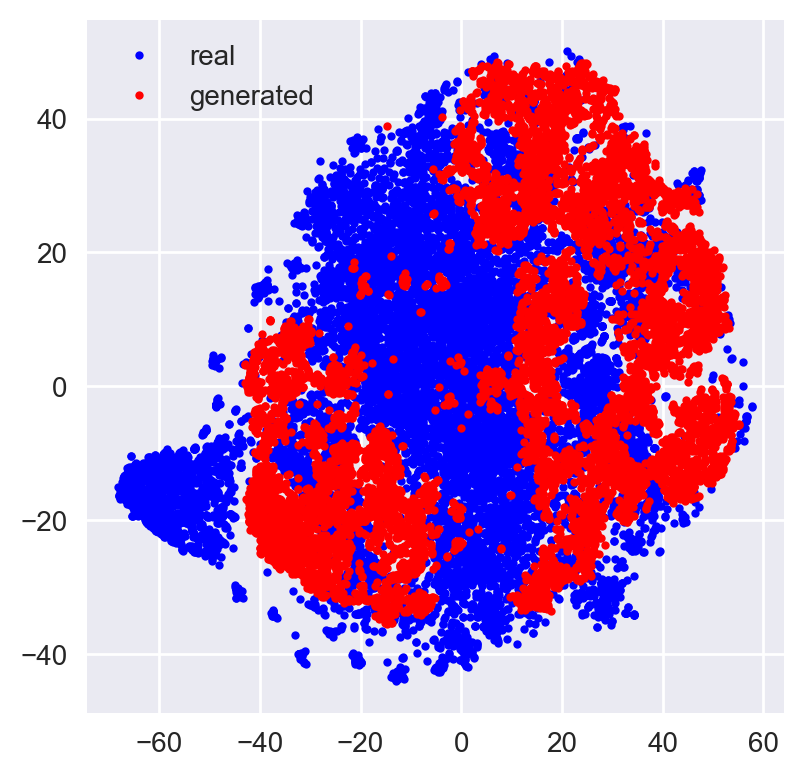

In [16]:
matplotlib.rcParams.update({'font.size': 10})
plt.style.use('seaborn')
fig,ax = plt.subplots(figsize=(4.5,4.5), dpi=200)
ax.plot(x_real_embed[:,0], x_real_embed[:,1], 'bo', color='blue', markersize=3, label='real')
ax.plot(x_fake_embed[:,0], x_fake_embed[:,1], 'bo', color='red', markersize=3, label='generated')
plt.legend()

<AxesSubplot:>

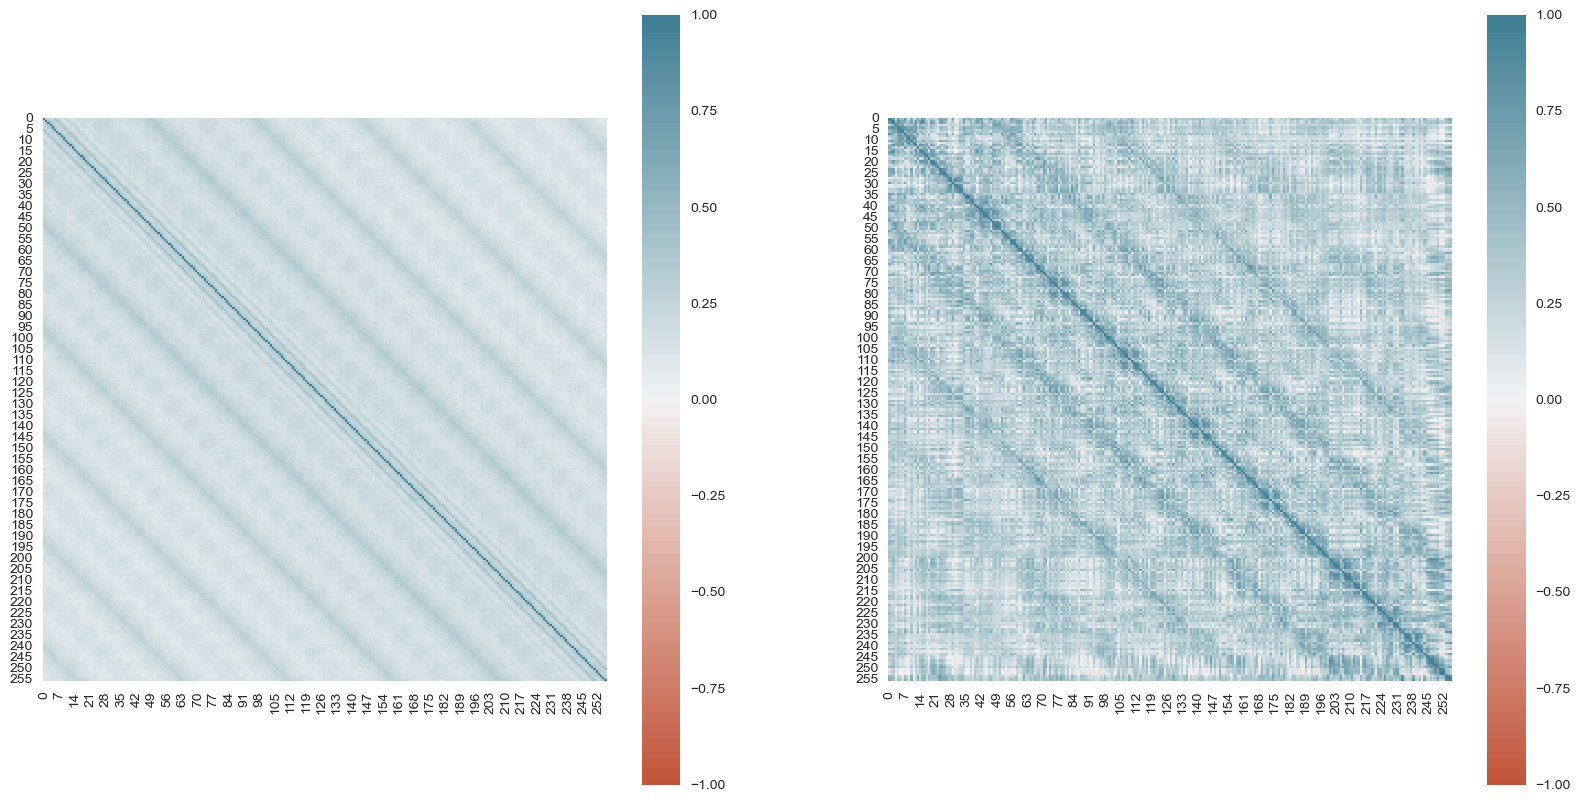

In [24]:
data_real = x_real.numpy().squeeze()
data_gen = x_gen.numpy().squeeze()

df_real = pd.DataFrame(data_real)
df_fake = pd.DataFrame(data_gen)
corr_real = df_real.corr()
corr_fake = df_fake.corr()

fig, axs = plt.subplots(ncols=2, figsize=(20,10))
sns.heatmap(
    corr_real,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, ax = axs[0]
    )
#axs[0].set_title("Correlation matrix of {} {} h samples".format(size, window_width))
#axs[1].set_title("Correlation matrix of {} {} h generated samples, model: {}".format(size,
  #                                                                      window_width, model_cls.__name__))
sns.heatmap(
        corr_fake,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, ax = axs[1]
        )


In [2]:
asset_lists = ['MAC000002', 'MAC000003', 'MAC000004', 'MAC000005','MAC000006','MAC000007', 'MAC000008', 'MAC000009']
dataset = ProgressiveDataset(asset_lists, data_dir='../WGAN/data/Small_LCL_Data', output_dir='./train_data',
                             window_length=8, target_len=64, overlap=48)
config = yaml.safe_load(open('config.yml', 'r'))
train_params = config['train_params']
dis_params = config['dis_params']
gen_params = config['gen_params']

In [4]:
trainer = TrainerProGAN(train_params, dis_params, gen_params)

In [5]:
trainer._build_model(load=True)

In [13]:
summary(trainer.model.discriminator, (1,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 32]              64
         LeakyReLU-2               [-1, 32, 32]               0
            Conv1d-3               [-1, 32, 32]           7,200
         LeakyReLU-4               [-1, 32, 32]               0
         ConvBlock-5               [-1, 32, 32]               0
            Conv1d-6               [-1, 32, 16]           7,200
         LeakyReLU-7               [-1, 32, 16]               0
         ConvBlock-8               [-1, 32, 16]               0
            Conv1d-9                [-1, 32, 8]           7,200
        LeakyReLU-10                [-1, 32, 8]               0
        ConvBlock-11                [-1, 32, 8]               0
           Conv1d-12                 [-1, 1, 8]              33
        LeakyReLU-13                 [-1, 1, 8]               0
           Linear-14                   

In [12]:
summary(trainer.model.generator, (1,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 32, 8]             256
         LeakyReLU-2                [-1, 32, 8]               0
         ConvBlock-3                [-1, 32, 8]               0
            Conv1d-4               [-1, 32, 16]           7,200
         LeakyReLU-5               [-1, 32, 16]               0
         ConvBlock-6               [-1, 32, 16]               0
            Conv1d-7               [-1, 32, 32]           7,200
         LeakyReLU-8               [-1, 32, 32]               0
         ConvBlock-9               [-1, 32, 32]               0
           Conv1d-10               [-1, 32, 64]           7,200
        LeakyReLU-11               [-1, 32, 64]               0
        ConvBlock-12               [-1, 32, 64]               0
           Conv1d-13              [-1, 32, 128]           7,200
        LeakyReLU-14              [-1, 

In [14]:
trainer._train(dataset)

In [9]:
def plot_samples(generator, depth: int = 0, n_rows: int = 4, n_cols: int = 4):

    z = torch.randn(n_rows*n_cols, generator.nb_features, generator.target_len).float()
    generator.eval()
    x_gen = generator(z, depth=depth, residual=False).detach()
    x_gen = x_gen.cpu().numpy().reshape(n_rows*n_cols, -1)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15), sharex=True)
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].plot(x_gen[count, :], color='black')
            count += 1
    fig.text(0.5, 0.06, 'time steps', ha='center', va='center', fontsize=15)

    return fig


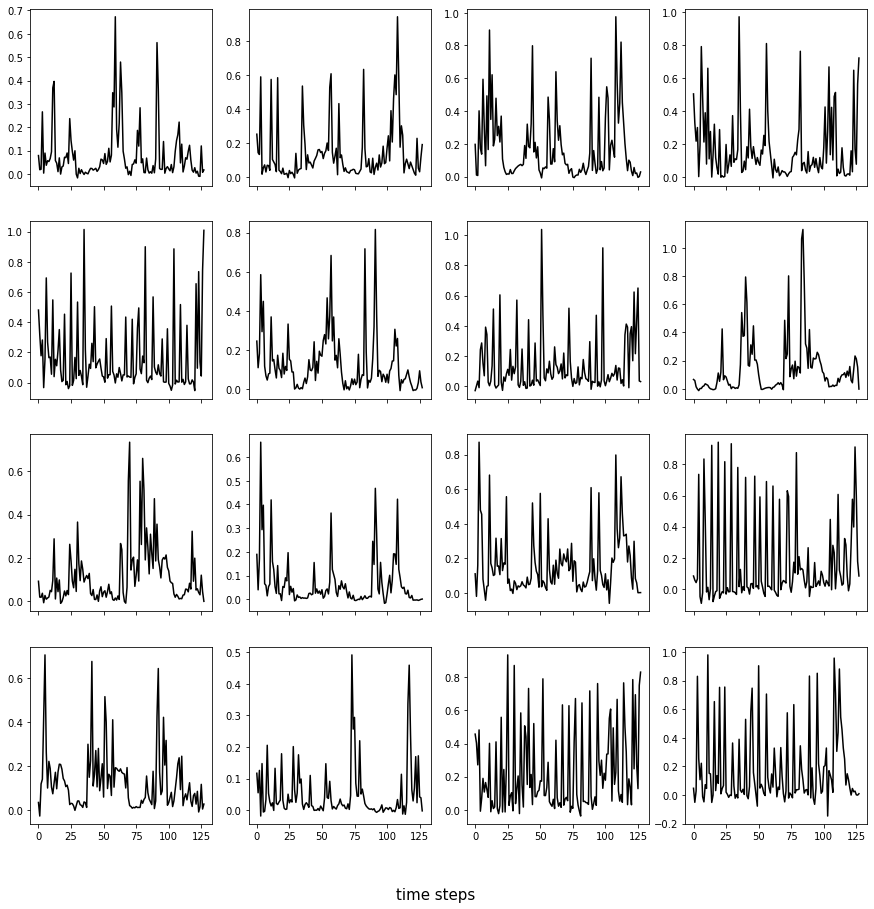

In [10]:
fig = plot_samples(trainer.model.generator, depth=4)

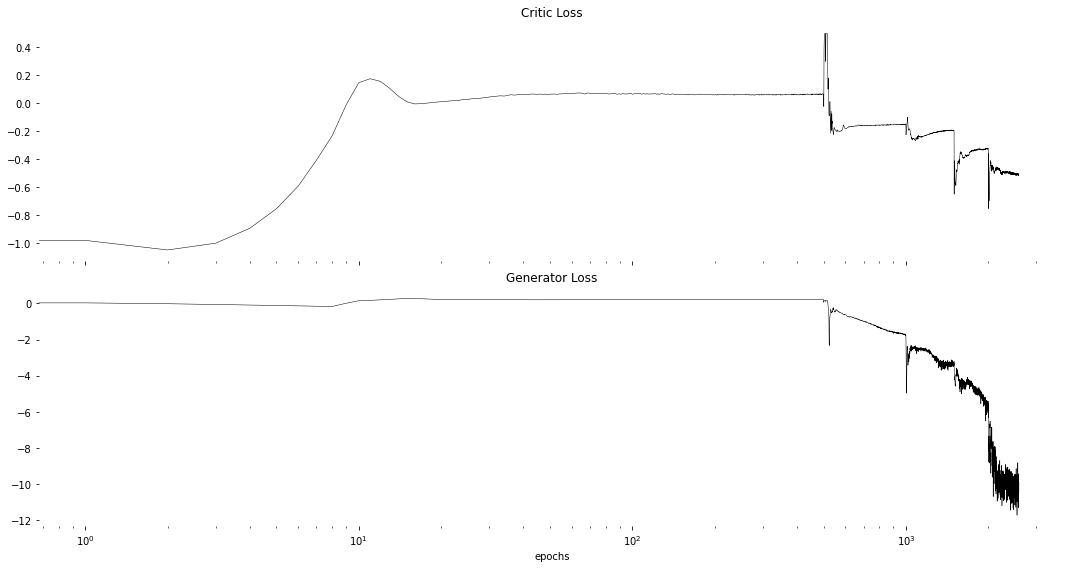

In [8]:
history = trainer.model.history
fig_losses = plot_losses(history)

In [11]:
def plot_real_samples(dataset, depth: int = 0, n_rows: int=5, n_cols: int = 5):

    loader = create_dataloader(dataset, step=depth, shuffle=True, batch_size=n_rows*n_cols)
    x_real = next(iter(loader)).cpu().numpy().reshape(n_rows*n_cols, -1)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,15), sharex=True)
    count = 0
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].plot(x_real[count, :], color='black')
            count += 1
    fig.text(0.5, 0.06, 'time steps', ha='center', va='center', fontsize=15)

    return fig


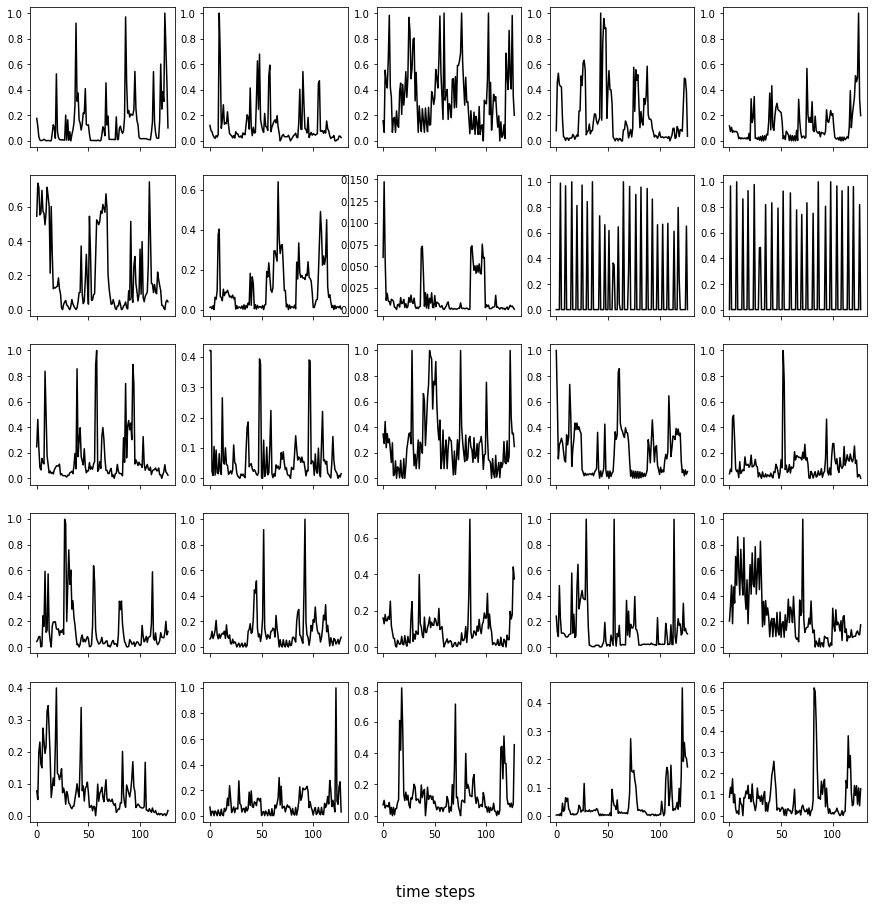

In [12]:
fig = plot_real_samples(dataset, depth=4)

In [16]:
x_gen = trainer.model.sample(size=5000, depth=4, clip=True)
x_real = load_real_data(dataset, size=5000)



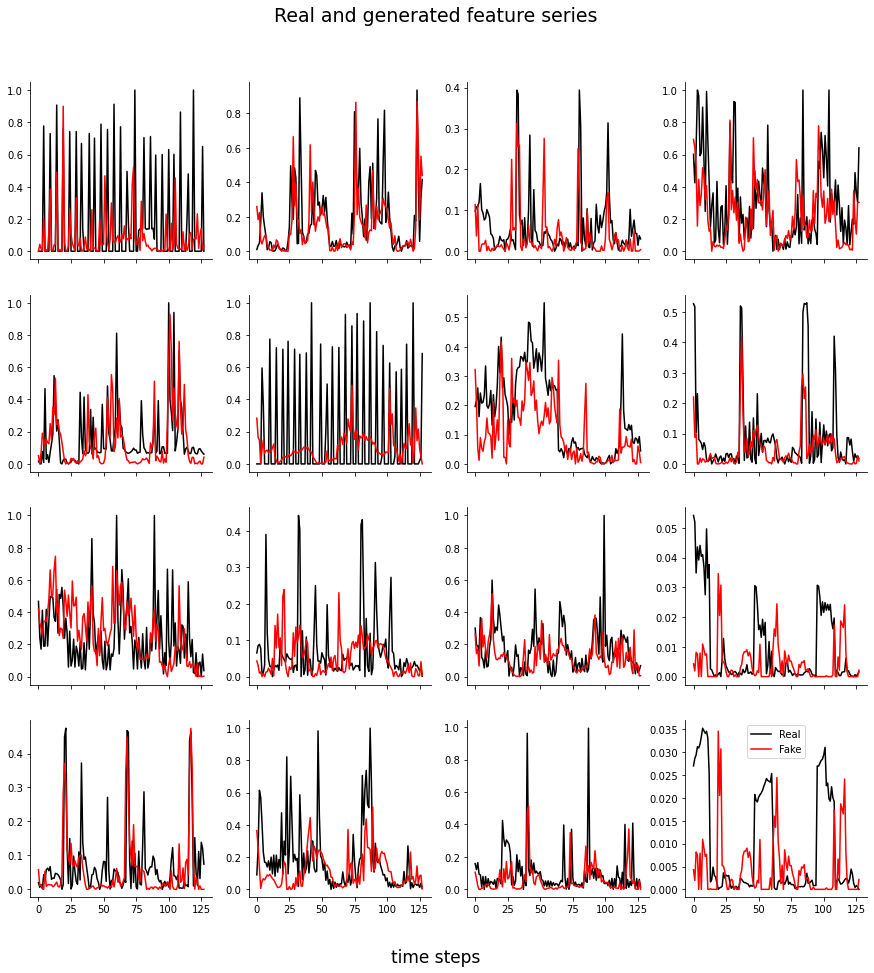

In [19]:
fig = plot_similar_samples(x_real, x_gen, figsize=(15,15))